<a href="https://colab.research.google.com/github/pratik7191/random-forest-streamlit-app/blob/main/Master%20Code%20Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
from csv import QUOTE_MINIMAL

# Load the dataset with error handling
data_path = "/content/Capstone Trade-in Dataset 121124 (1).csv"
try:
    data = pd.read_csv(data_path, quoting=QUOTE_MINIMAL, on_bad_lines='skip')  # Skip problematic lines
    # Print sample and column details
    print("Dataset Columns:", data.columns)
    print("Sample Rows:", data.head())
except Exception as e:
    print("Error reading the file:", e)


<ipython-input-2-42db5db6f14a>:8: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path, quoting=QUOTE_MINIMAL, on_bad_lines='skip')  # Skip problematic lines


Dataset Columns: Index(['tradein_ref_id', 'trade_in_status', 'trade_in_datetime',
       'diagnosis_done', 'offer_program_name', 'IMEI', 'IMEI_upgraded_device',
       'trade_in_price_offered_to_the_customer',
       'trade_in_price_offered_to_the_retailer', 'device_grade',
       'liquidator_type', 'requote_value', 'offer_value', 'new_device_brand',
       'liq_p_flag', 'partner_id', 'product_id', 'psl_id',
       'old_device_brand_id', 'dt_of_purchase', 'is_under_warranty',
       'warranty_till_dt', 'name_of_firm', 'service_location_name', 'zip_code',
       'brand_name', 'product_name'],
      dtype='object')
Sample Rows:   tradein_ref_id trade_in_status trade_in_datetime  diagnosis_done  \
0   GKAL1ZXVZHDO          Failed           21:34.0               1   
1   IGG4VYQOYU6J          Failed           31:12.0               1   
2   8VUMFNU7WH1P          Failed           51:41.0               1   
3   ARYFHWQEDROQ          Failed           54:46.0               1   
4   MMSBWLHGR8B5

In [ ]:
data.shape

(1048575, 27)

In [ ]:
# Convert date/time columns
if 'trade_in_datetime' in data.columns:
    data['trade_in_datetime'] = pd.to_datetime(data['trade_in_datetime'], errors='coerce')

# Ensure numerical columns are in correct type
for col in ['trade_in_price_offered_to_the_customer', 'trade_in_price_offered_to_the_retailer']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Categorical encoding (Example: device_grade)
if 'device_grade' in data.columns:
    data['device_grade_encoded'] = data['device_grade'].astype('category').cat.codes


<ipython-input-4-6099dd56c7ad>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['trade_in_datetime'] = pd.to_datetime(data['trade_in_datetime'], errors='coerce')


In [ ]:
# Drop irrelevant columns
columns_to_drop = ['tradein_ref_id', 'IMEI', 'name_of_firm', 'service_location_name', 'zip_code', 'product_name']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

# Check the remaining columns
print("Remaining Columns:", data.columns)


Remaining Columns: Index(['trade_in_status', 'trade_in_datetime', 'diagnosis_done',
       'offer_program_name', 'IMEI_upgraded_device',
       'trade_in_price_offered_to_the_customer',
       'trade_in_price_offered_to_the_retailer', 'device_grade',
       'liquidator_type', 'requote_value', 'offer_value', 'new_device_brand',
       'liq_p_flag', 'partner_id', 'product_id', 'psl_id',
       'old_device_brand_id', 'dt_of_purchase', 'is_under_warranty',
       'warranty_till_dt', 'brand_name', 'device_grade_encoded'],
      dtype='object')


In [ ]:
# Fill missing values in numerical columns with mean
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col].fillna(data[col].mean(), inplace=True)

# Fill missing values in categorical columns with mode
for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Drop columns with more than 80% missing values
threshold = 0.8
data = data.loc[:, data.isnull().mean() < threshold]


<ipython-input-6-ee2a319e6ec3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
<ipython-input-6-ee2a319e6ec3>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Specify the target column
target_column = 'trade_in_status'

# Ensure the target column is numeric
data[target_column] = data[target_column].astype('category').cat.codes

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Convert datetime columns to numeric features
if 'trade_in_datetime' in X.columns:
    X['trade_in_datetime'] = pd.to_datetime(X['trade_in_datetime'], errors='coerce')
    X['trade_in_year'] = X['trade_in_datetime'].dt.year
    X['trade_in_month'] = X['trade_in_datetime'].dt.month
    X['trade_in_day'] = X['trade_in_datetime'].dt.day
    X = X.drop(columns=['trade_in_datetime'])

# Encode categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = X[col].astype('category').cat.codes

# Fill missing values with 0
X = X.fillna(0)

# Verify that X is fully numeric
print("Data types after preprocessing:\n", X.dtypes)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


Data types after preprocessing:
 diagnosis_done                              int64
offer_program_name                           int8
IMEI_upgraded_device                        int16
trade_in_price_offered_to_the_customer    float64
trade_in_price_offered_to_the_retailer    float64
device_grade                                 int8
liquidator_type                              int8
requote_value                             float64
offer_value                               float64
new_device_brand                             int8
liq_p_flag                                  int64
partner_id                                  int64
product_id                                  int64
psl_id                                      int64
old_device_brand_id                         int64
dt_of_purchase                              int16
is_under_warranty                         float64
warranty_till_dt                            int16
brand_name                                   int8
device_grade_enco

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9644040721932146
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98    129828
           1       0.63      0.26      0.37      1205
           2       0.95      0.96      0.95     78682

    accuracy                           0.96    209715
   macro avg       0.85      0.73      0.77    209715
weighted avg       0.96      0.96      0.96    209715

Random Forest Accuracy: 0.9815940681400949
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    129828
           1       0.88      0.89      0.88      1205
           2       0.96      0.99      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.95      0.95    209715
weighted avg       0.98      0.98      0.98    209715

Gradient Boosting Accuracy: 0.9813651860858784
Classification Report:
               precision    

In [ ]:
# Calculate training and testing accuracies for each model
logreg_train_accuracy = accuracy_score(y_train, logreg.predict(X_train))
logreg_test_accuracy = accuracy_score(y_test, y_pred_logreg)

rf_train_accuracy = accuracy_score(y_train, rf.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)

gb_train_accuracy = accuracy_score(y_train, gb.predict(X_train))
gb_test_accuracy = accuracy_score(y_test, y_pred_gb)

# Prepare results as a DataFrame
results_summary = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Train Accuracy": [logreg_train_accuracy, rf_train_accuracy, gb_train_accuracy],
    "Test Accuracy": [logreg_test_accuracy, rf_test_accuracy, gb_test_accuracy]
}

results_df = pd.DataFrame(results_summary)

# Display the results
print("Model Training and Testing Accuracy:")
print(results_df)


Model Training and Testing Accuracy:
                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.964503       0.964404
1        Random Forest        0.995220       0.981594
2    Gradient Boosting        0.981648       0.981365


In [ ]:
# Get the number of rows and columns in the training and testing datasets
train_rows, train_columns = X_train.shape
test_rows, test_columns = X_test.shape

# Display the results
print(f"Training Dataset: {train_rows} rows and {train_columns} columns")
print(f"Testing Dataset: {test_rows} rows and {test_columns} columns")


Training Dataset: 838860 rows and 23 columns
Testing Dataset: 209715 rows and 23 columns


Confusion Matrix: Logistic Regression


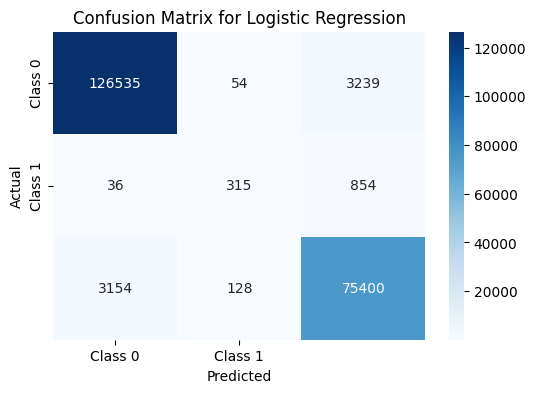

Confusion Matrix: Random Forest


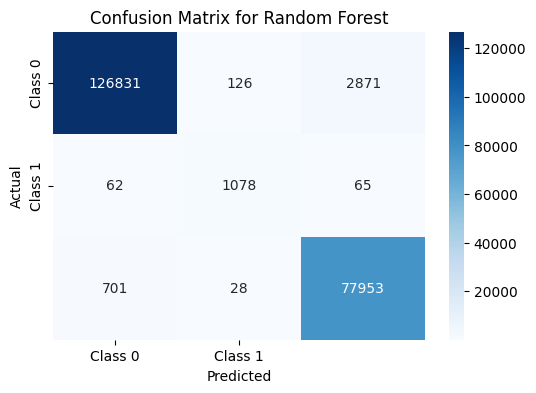

Confusion Matrix: Gradient Boosting


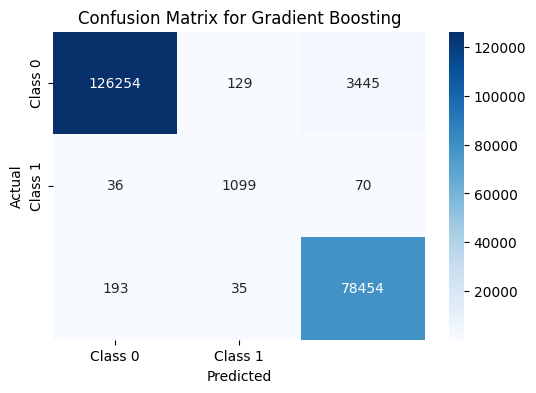

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Confusion Matrix for Logistic Regression
print("Confusion Matrix: Logistic Regression")
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")

# Confusion Matrix for Random Forest
print("Confusion Matrix: Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# Confusion Matrix for Gradient Boosting
print("Confusion Matrix: Gradient Boosting")
plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")


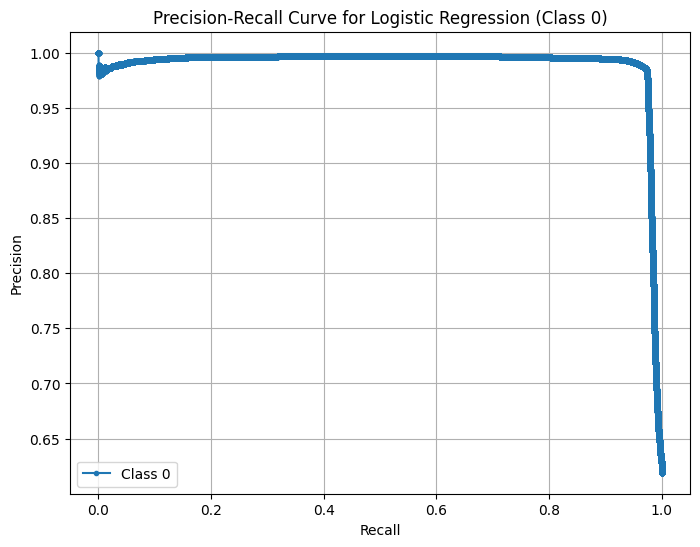

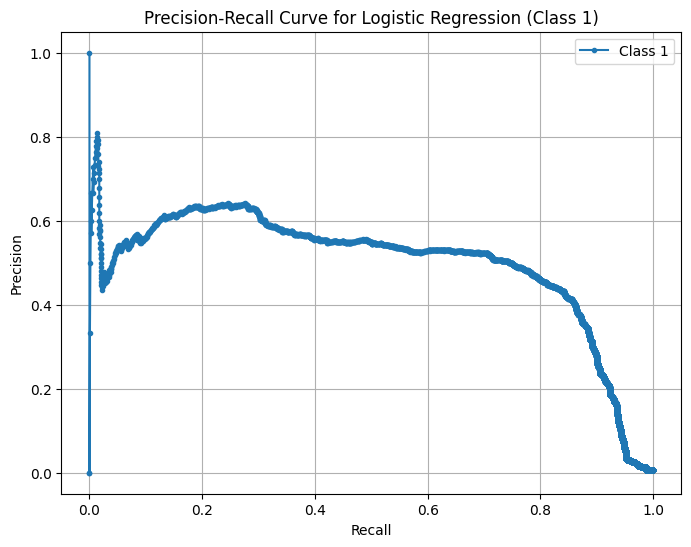

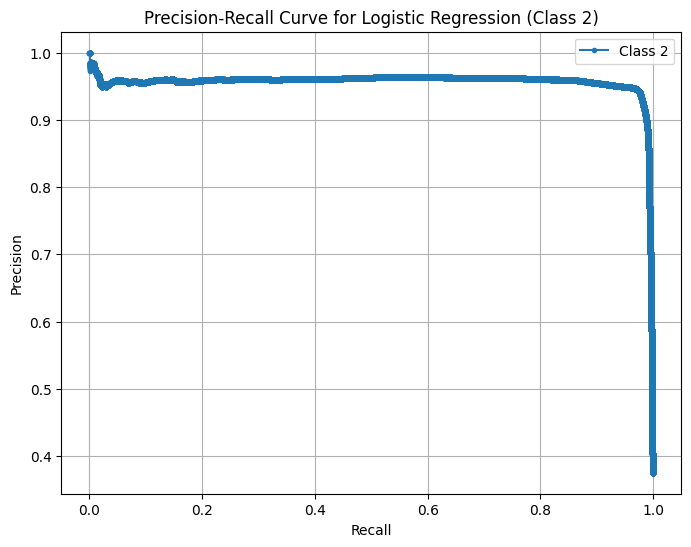

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Binarize the output (one-vs-rest for multiclass)
classes = sorted(y_test.unique())  # Ensure correct class order
y_test_binarized = label_binarize(y_test, classes=classes)

# Function to plot precision-recall curve for each class
def plot_precision_recall_multiclass(y_test_bin, y_scores, class_label, model_name):
    precision, recall, _ = precision_recall_curve(y_test_bin, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f"Class {class_label}")
    plt.title(f"Precision-Recall Curve for {model_name} (Class {class_label})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

# Logistic Regression Precision-Recall Curve for each class
logreg_probs = logreg.predict_proba(X_test)  # Multiclass probabilities
for i, class_label in enumerate(classes):
    plot_precision_recall_multiclass(y_test_binarized[:, i], logreg_probs[:, i], class_label, "Logistic Regression")

# Repeat for Random Forest and Gradient Boosting if needed


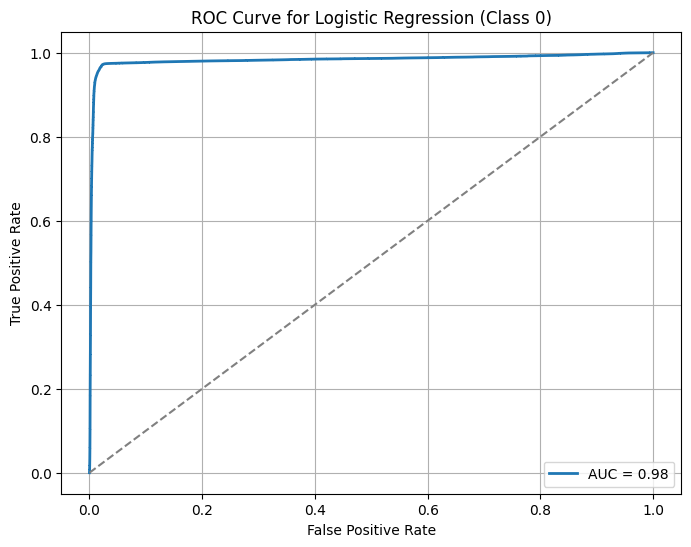

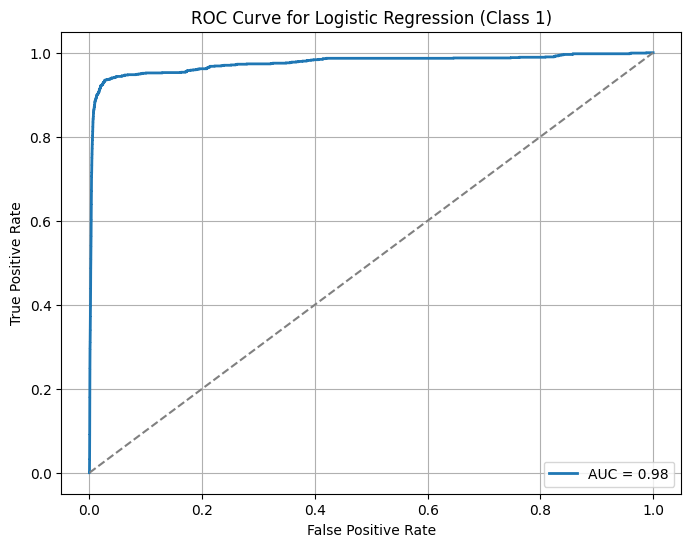

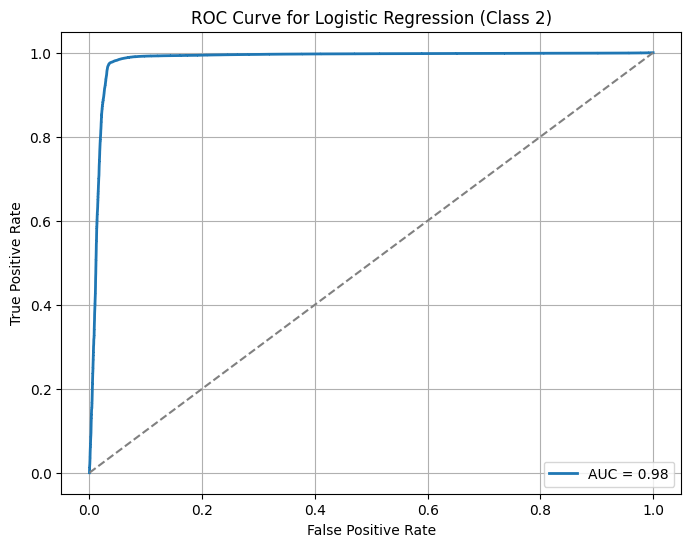

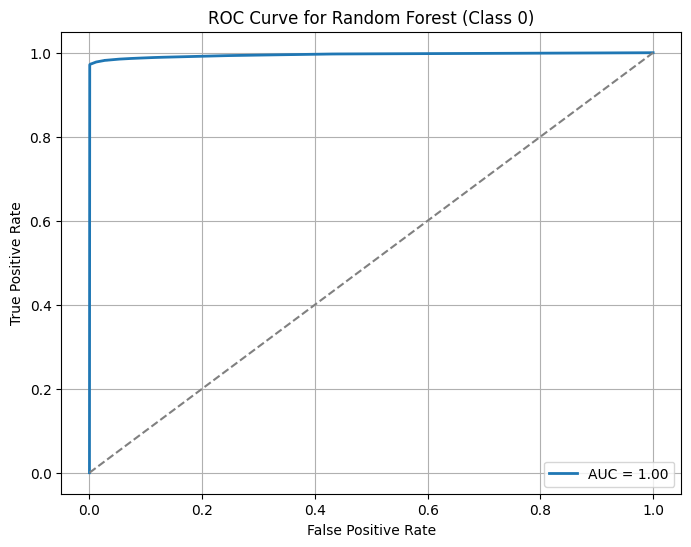

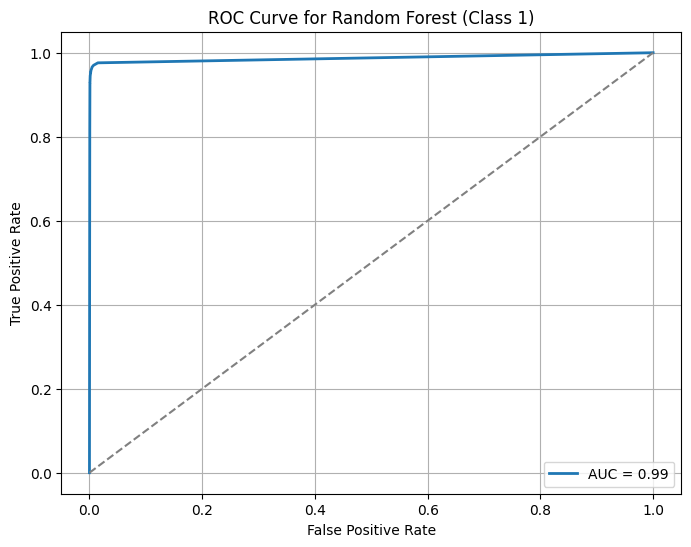

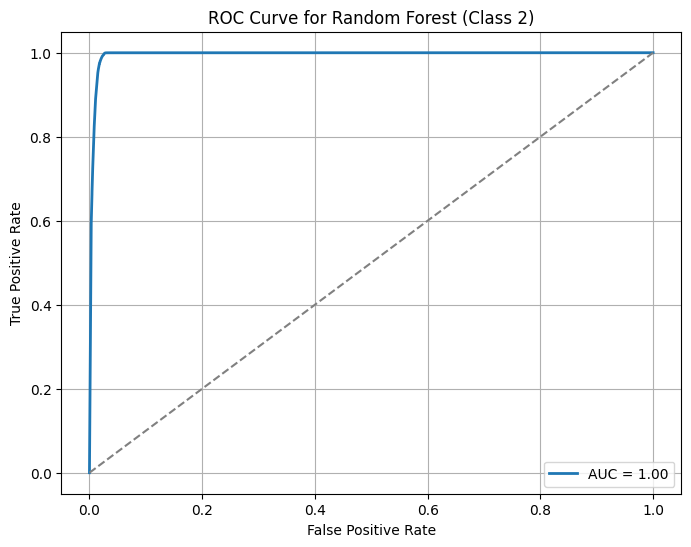

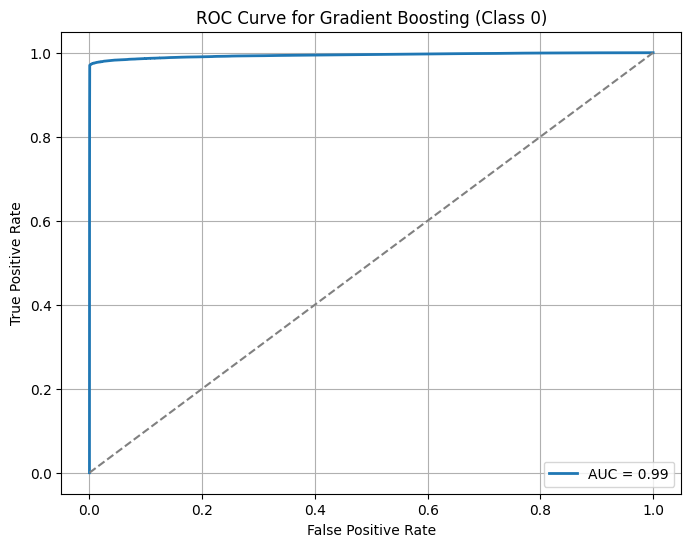

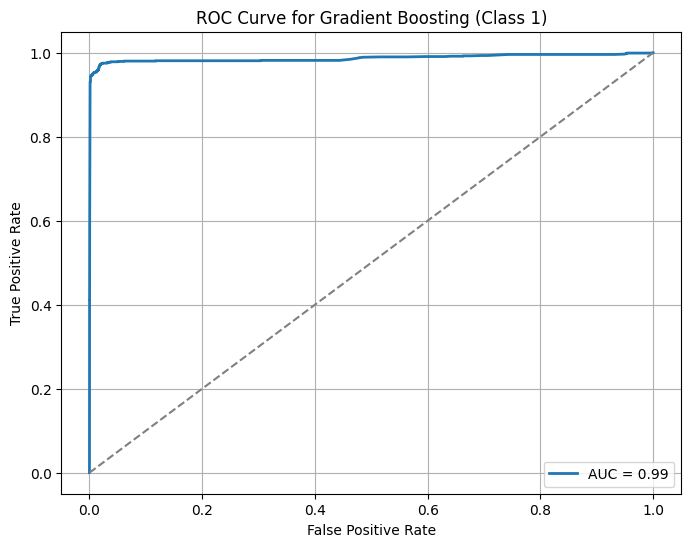

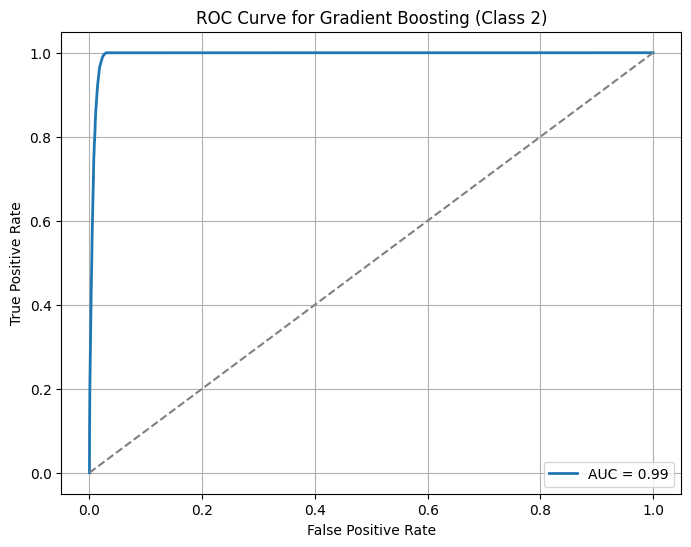

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target variable for multiclass (One-vs-Rest approach)
classes = sorted(y_test.unique())  # Ensure class order
y_test_binarized = label_binarize(y_test, classes=classes)

# Function to plot ROC curve for each class
def plot_roc_curve_multiclass(y_test_bin, y_scores, class_label, model_name):
    fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.title(f"ROC Curve for {model_name} (Class {class_label})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Logistic Regression ROC Curve for each class
logreg_probs = logreg.predict_proba(X_test)  # Multiclass probabilities
for i, class_label in enumerate(classes):
    plot_roc_curve_multiclass(y_test_binarized[:, i], logreg_probs[:, i], class_label, "Logistic Regression")

# Random Forest ROC Curve for each class
rf_probs = rf.predict_proba(X_test)  # Multiclass probabilities
for i, class_label in enumerate(classes):
    plot_roc_curve_multiclass(y_test_binarized[:, i], rf_probs[:, i], class_label, "Random Forest")

# Gradient Boosting ROC Curve for each class
gb_probs = gb.predict_proba(X_test)  # Multiclass probabilities
for i, class_label in enumerate(classes):
    plot_roc_curve_multiclass(y_test_binarized[:, i], gb_probs[:, i], class_label, "Gradient Boosting")


Full Grown Tree Accuracy Score: 0.9731

Classification Report for Full Grown Tree:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    129828
           1       0.83      0.81      0.82      1205
           2       0.97      0.97      0.97     78682

    accuracy                           0.97    209715
   macro avg       0.93      0.92      0.92    209715
weighted avg       0.97      0.97      0.97    209715


Confusion Matrix for Full Grown Tree:
[[127137    141   2550]
 [   165    976     64]
 [  2676     52  75954]]


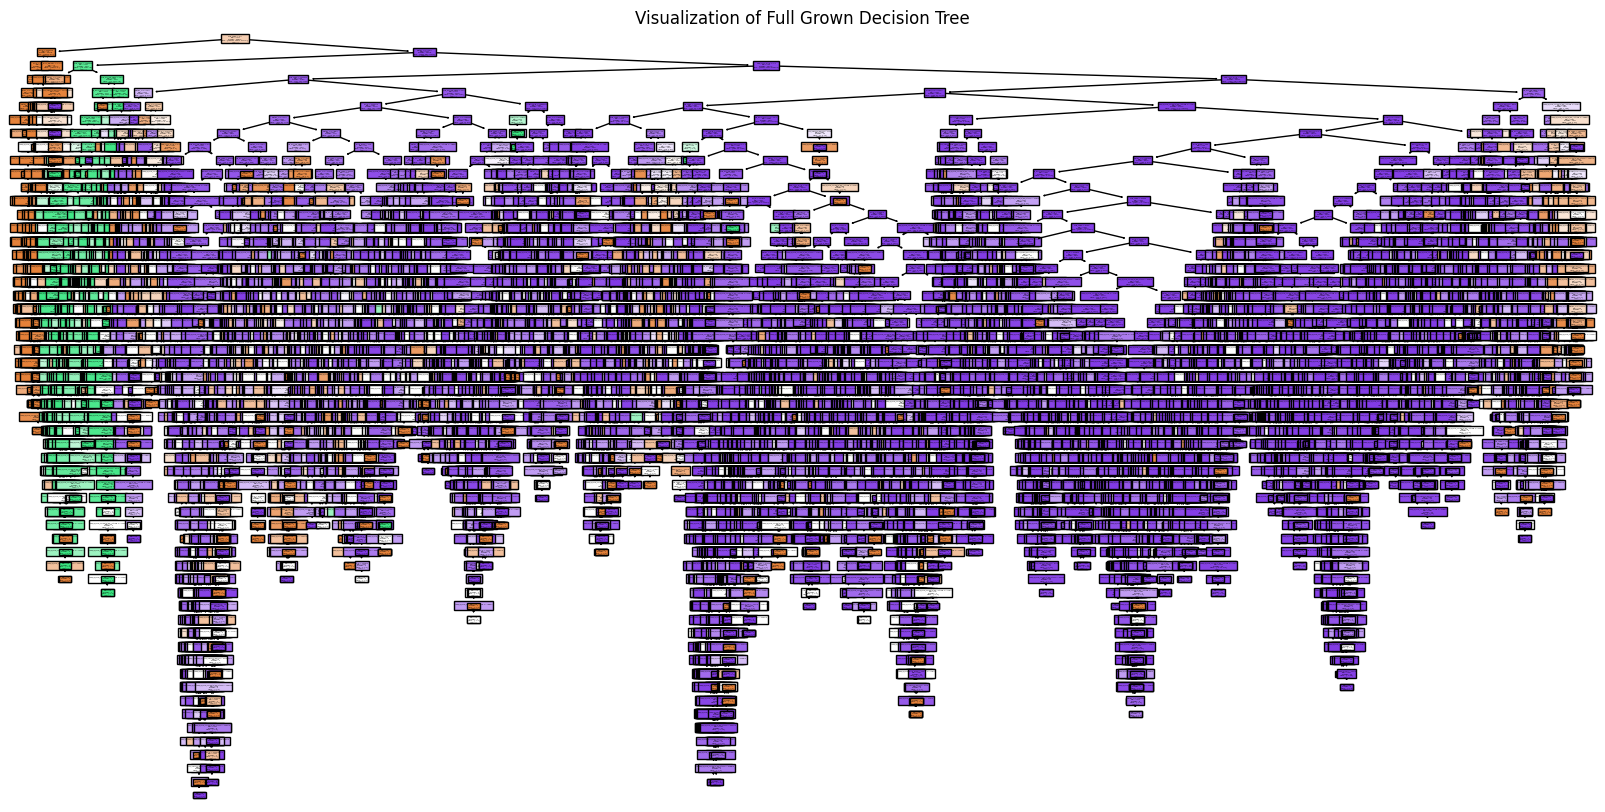

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train a full-grown decision tree
fulltree = DecisionTreeClassifier(random_state=0)  # No restrictions on depth or splits
fulltree.fit(X_train, y_train)

# Predict on test data
fulltree_predictions = fulltree.predict(X_test)

# Evaluate the full-grown tree
fulltree_accuracy = accuracy_score(y_test, fulltree_predictions)
print(f"Full Grown Tree Accuracy Score: {fulltree_accuracy:.4f}")

print("\nClassification Report for Full Grown Tree:")
print(classification_report(y_test, fulltree_predictions))

# Print the confusion matrix
fulltree_conf_matrix = confusion_matrix(y_test, fulltree_predictions)
print("\nConfusion Matrix for Full Grown Tree:")
print(fulltree_conf_matrix)

# Visualize the full-grown tree
plt.figure(figsize=(20, 10))
plot_tree(fulltree, feature_names=X_train.columns, class_names=y_train.unique().astype(str), filled=True)
plt.title("Visualization of Full Grown Decision Tree")
plt.show()


Small Tree Accuracy Score: 0.9805

Classification Report for Small Tree:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    129828
           1       0.86      0.92      0.89      1205
           2       0.95      1.00      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.96      0.95    209715
weighted avg       0.98      0.98      0.98    209715


Confusion Matrix for Small Tree:
[[125864    152   3812]
 [    23   1110     72]
 [     1     31  78650]]


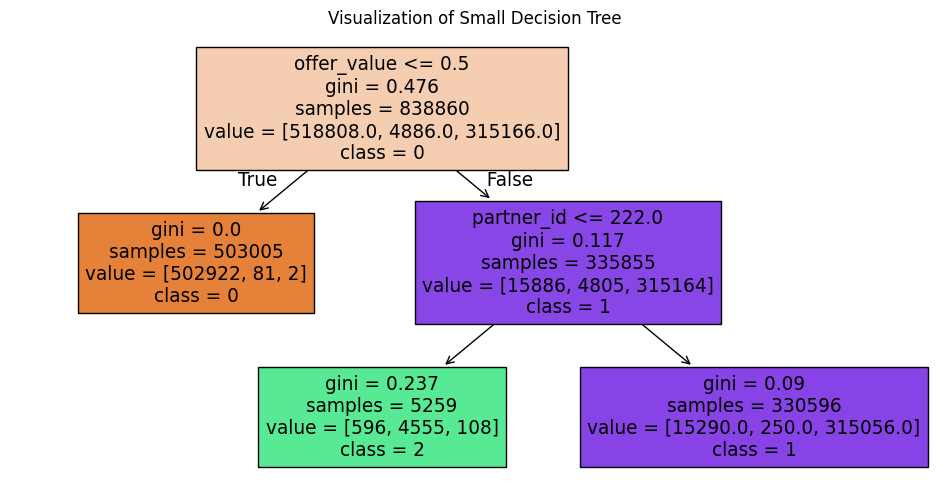

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train a small decision tree to avoid overfitting
smallCtree = DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=20,
    min_impurity_decrease=0.01,
    random_state=0
)
smallCtree.fit(X_train, y_train)

# Predict on test data
smallCtree_predictions = smallCtree.predict(X_test)

# Evaluate the small tree
smallCtree_accuracy = accuracy_score(y_test, smallCtree_predictions)
print(f"Small Tree Accuracy Score: {smallCtree_accuracy:.4f}")

print("\nClassification Report for Small Tree:")
print(classification_report(y_test, smallCtree_predictions))

# Print the confusion matrix
smallCtree_conf_matrix = confusion_matrix(y_test, smallCtree_predictions)
print("\nConfusion Matrix for Small Tree:")
print(smallCtree_conf_matrix)

# Visualize the small tree
plt.figure(figsize=(12, 6))
plot_tree(smallCtree, feature_names=X_train.columns, class_names=y_train.unique().astype(str), filled=True)
plt.title("Visualization of Small Decision Tree")
plt.show()


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_split': 50}

Best Cross-Validation Score: 0.981840831604797

Detailed Results:
    mean_test_score  std_test_score  \
0          0.980537        0.000146   
1          0.980537        0.000146   
2          0.980537        0.000146   
3          0.980537        0.000146   
4          0.980537        0.000146   
5          0.980537        0.000146   
6          0.975235        0.000145   
7          0.975235        0.000145   
8          0.975235        0.000145   
9          0.981238        0.000188   
10         0.981238        0.000188   
11         0.981238        0.000188   
12         0.980537        0.000146   
13         0.980537        0.000146   
14         0.980537        0.000146   
15         0.975235        0.000145   
16         0.975235        0.000145   
17         0.975235        0.000145   
18         0.981837        0.000189   


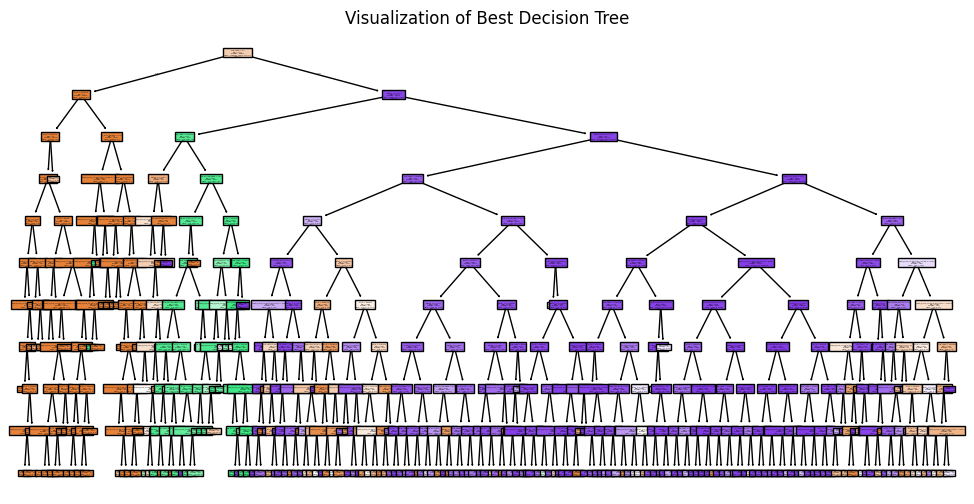

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

# Function to print GridSearch results
def print_results(gridsearch):
    print("\nBest Parameters:", gridsearch.best_params_)
    print("\nBest Cross-Validation Score:", gridsearch.best_score_)
    print("\nDetailed Results:")
    results = pd.DataFrame(gridsearch.cv_results_)
    print(results[['mean_test_score', 'std_test_score', 'params']])

# Define the parameter grid
param_grid = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [10, 20, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

# Initialize the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)

# Initialize GridSearchCV
gridsearch = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1
)

# Run GridSearch
gridsearch.fit(X_train, y_train)

# Print the GridSearch results
print_results(gridsearch)

# Use the best estimator to make predictions
best_model = gridsearch.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
best_model_accuracy = accuracy_score(y_test, y_pred_best)
print("\nAccuracy of Best Model on Test Data:", best_model_accuracy)

# Print classification report
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

# Visualize the best decision tree
plt.figure(figsize=(12, 6))
plot_tree(best_model, feature_names=X_train.columns, class_names=y_train.unique().astype(str), filled=True)
plt.title("Visualization of Best Decision Tree")
plt.show()


In [ ]:
#Take the best estimator
bestCtree = gridsearch.best_estimator_

In [ ]:
predictions = bestCtree.predict(X_test)

In [ ]:
print(accuracy_score(y_test, predictions))

0.9817037407910736


In [ ]:
cm = confusion_matrix(y_test, predictions)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[126409    129   3290]
 [    37   1098     70]
 [   278     33  78371]]


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    129828
           1       0.87      0.91      0.89      1205
           2       0.96      1.00      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.96      0.95    209715
weighted avg       0.98      0.98      0.98    209715



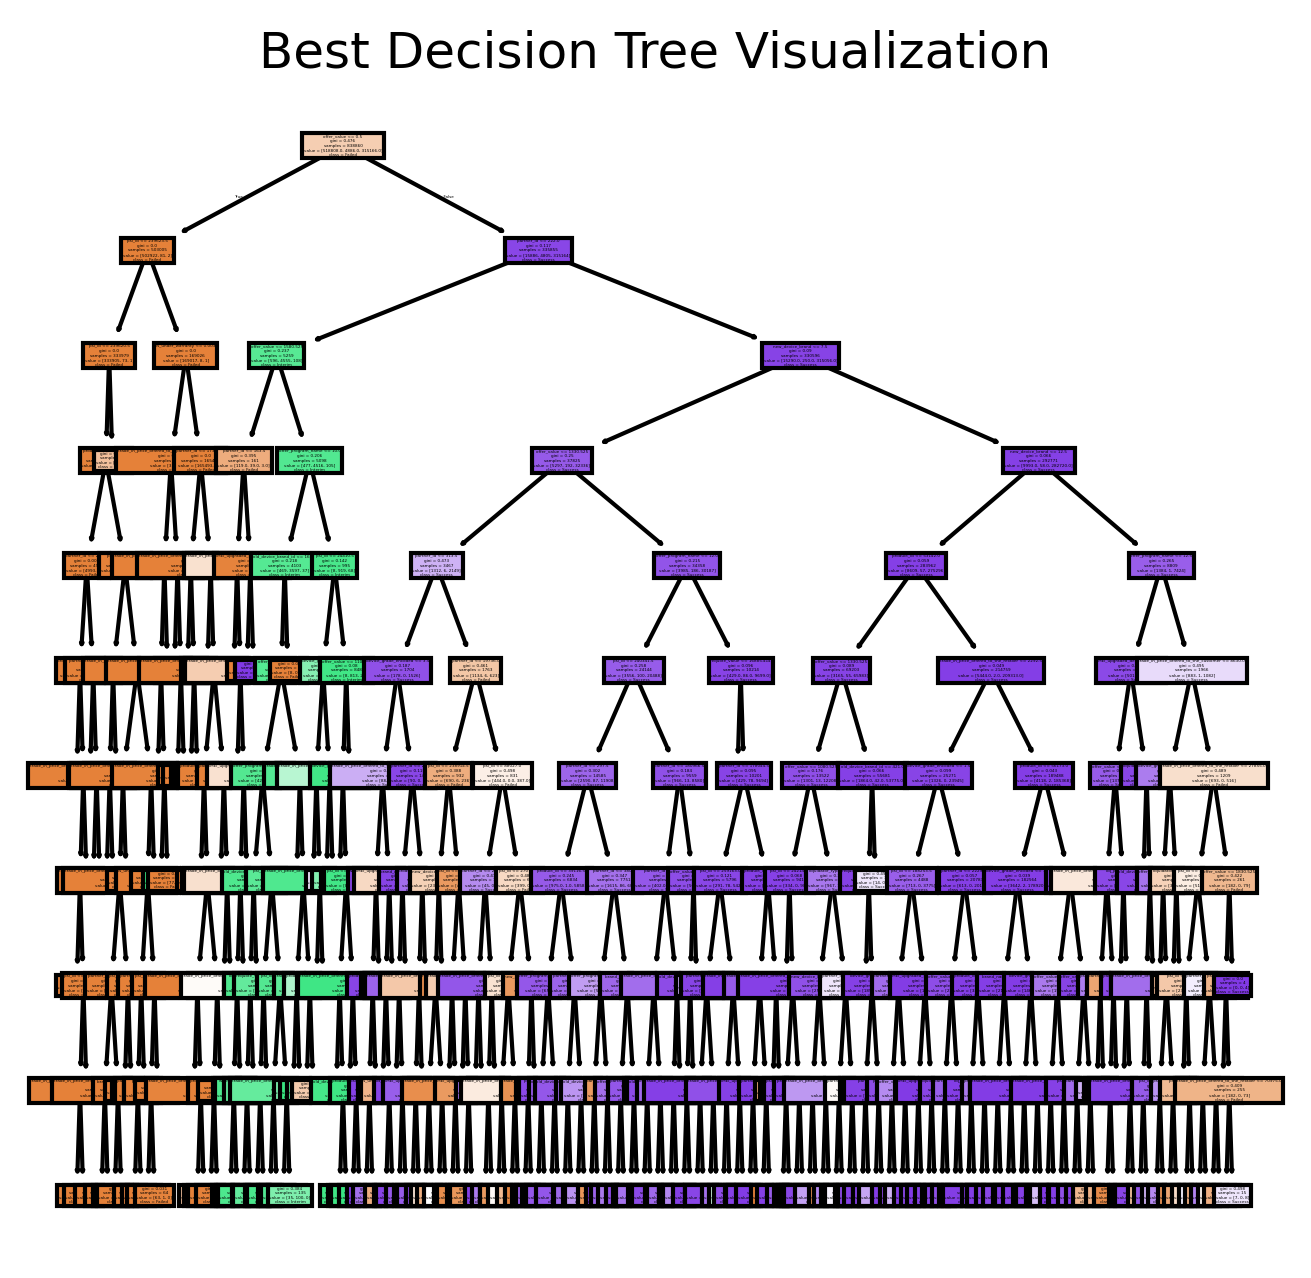

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the best decision tree using the sample code style
fig = plt.figure(figsize=(5, 5), dpi=300)  # Set the figure size and DPI
_ = plot_tree(
    best_model,  # Replace with your best decision tree model
    feature_names=X.columns,  # Replace with feature names from your dataset
    class_names=['Failed', 'Interim','Success'],  # Replace with the actual class labels
    filled=True  # Colors the nodes based on the majority class
)
plt.title("Best Decision Tree Visualization", fontsize=12)  # Add a title
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [ ]:
log_clf = LogisticRegression()
dtr_clf = DecisionTreeClassifier()
svm_clf = SVC(probability=True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create an object for Bagging Classifier (Pasting)
pasting_classifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),  # Replace base_estimator with estimator
    n_estimators=50,  # Number of trees
    bootstrap=False,  # Pasting does not use bootstrap sampling
    random_state=42
)

# Train the Pasting Classifier
pasting_classifier.fit(X_train, y_train)

# Predict using the Pasting Classifier
pasting_predictions = pasting_classifier.predict(X_test)

# Check the performance for Pasting
pasting_accuracy = accuracy_score(y_test, pasting_predictions)
print(f"Pasting Accuracy: {pasting_accuracy:.4f}")

print("\nClassification Report for Pasting:")
print(classification_report(y_test, pasting_predictions))

print("\nConfusion Matrix for Pasting:")
print(confusion_matrix(y_test, pasting_predictions))

# Create an object for Bagging Classifier with Out-of-Bag Evaluation
bagging_classifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),  # Replace base_estimator with estimator
    n_estimators=50,  # Number of trees
    bootstrap=True,  # Bagging uses bootstrap sampling
    oob_score=True,  # Enables out-of-bag evaluation
    random_state=42
)

# Train the Bagging Classifier
bagging_classifier.fit(X_train, y_train)

# Get the Out-of-Bag Evaluation Score
oob_score = bagging_classifier.oob_score_
print(f"\nOut-of-Bag Score: {oob_score:.4f}")

# Predict using the Bagging Classifier
bagging_predictions = bagging_classifier.predict(X_test)

# Check the performance for Bagging
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print(f"Bagging Accuracy: {bagging_accuracy:.4f}")

print("\nClassification Report for Bagging:")
print(classification_report(y_test, bagging_predictions))

print("\nConfusion Matrix for Bagging:")
print(confusion_matrix(y_test, bagging_predictions))


Pasting Accuracy: 0.9739

Classification Report for Pasting:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    129828
           1       0.83      0.81      0.82      1205
           2       0.97      0.97      0.97     78682

    accuracy                           0.97    209715
   macro avg       0.93      0.92      0.92    209715
weighted avg       0.97      0.97      0.97    209715


Confusion Matrix for Pasting:
[[127152    143   2533]
 [   167    971     67]
 [  2510     56  76116]]

Out-of-Bag Score: 0.9812
Bagging Accuracy: 0.9813

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    129828
           1       0.88      0.89      0.88      1205
           2       0.97      0.99      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.95      0.95      0.95    209715
weighted avg       0.98      0.98      0.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create an object for Bagging Classifier (Pasting)
pasting_classifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),  # Replace base_estimator with estimator
    n_estimators=50,  # Number of trees
    bootstrap=False,  # Pasting does not use bootstrap sampling
    random_state=42
)

# Train the Pasting Classifier
pasting_classifier.fit(X_train, y_train)

# Predict using the Pasting Classifier
pasting_predictions = pasting_classifier.predict(X_test)

# Check the performance for Pasting
pasting_accuracy = accuracy_score(y_test, pasting_predictions)
print(f"Pasting Accuracy: {pasting_accuracy:.4f}")

print("\nClassification Report for Pasting:")
print(classification_report(y_test, pasting_predictions))

print("\nConfusion Matrix for Pasting:")
print(confusion_matrix(y_test, pasting_predictions))

# Create an object for Bagging Classifier with Out-of-Bag Evaluation
bagging_classifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),  # Replace base_estimator with estimator
    n_estimators=50,  # Number of trees
    bootstrap=True,  # Bagging uses bootstrap sampling
    oob_score=True,  # Enables out-of-bag evaluation
    random_state=42
)

# Train the Bagging Classifier
bagging_classifier.fit(X_train, y_train)

# Get the Out-of-Bag Evaluation Score
oob_score = bagging_classifier.oob_score_
print(f"\nOut-of-Bag Score: {oob_score:.4f}")

# Predict using the Bagging Classifier
bagging_predictions = bagging_classifier.predict(X_test)

# Check the performance for Bagging
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print(f"Bagging Accuracy: {bagging_accuracy:.4f}")

print("\nClassification Report for Bagging:")
print(classification_report(y_test, bagging_predictions))

print("\nConfusion Matrix for Bagging:")
print(confusion_matrix(y_test, bagging_predictions))


Pasting Accuracy: 0.9739

Classification Report for Pasting:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    129828
           1       0.83      0.81      0.82      1205
           2       0.97      0.97      0.97     78682

    accuracy                           0.97    209715
   macro avg       0.93      0.92      0.92    209715
weighted avg       0.97      0.97      0.97    209715


Confusion Matrix for Pasting:
[[127152    143   2533]
 [   167    971     67]
 [  2510     56  76116]]

Out-of-Bag Score: 0.9812
Bagging Accuracy: 0.9813

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    129828
           1       0.88      0.89      0.88      1205
           2       0.97      0.99      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.95      0.95      0.95    209715
weighted avg       0.98      0.98      0.

Random Forest Accuracy: 0.9815

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    129828
           1       0.88      0.89      0.88      1205
           2       0.96      0.99      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.95      0.95    209715
weighted avg       0.98      0.98      0.98    209715


Confusion Matrix:
 [[126805    123   2900]
 [    70   1071     64]
 [   693     28  77961]]


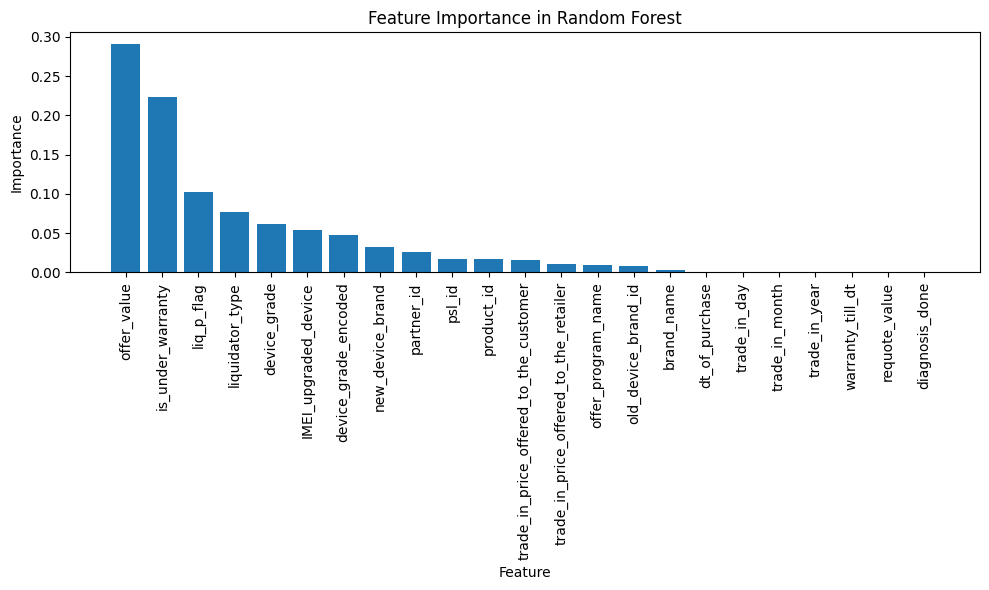

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create an object for Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 2: Fit the model
rf_classifier.fit(X_train, y_train)

# Step 3: Predict using the model
pred_rf = rf_classifier.predict(X_test)

# Step 4: Check the accuracy score
rf_accuracy = accuracy_score(y_test, pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Print classification report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, pred_rf))

# Print confusion matrix
cm = confusion_matrix(y_test, pred_rf)
print("\nConfusion Matrix:\n", cm)

# Step 5: Print feature importance with a plot
feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.title("Feature Importance in Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()




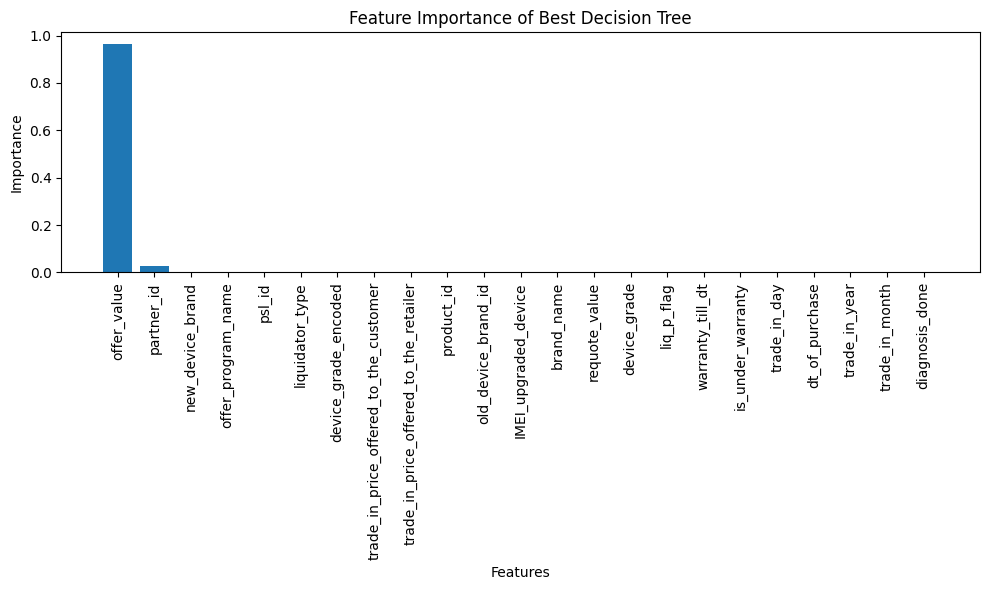

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance of the best decision tree
best_tree_feature_importances = best_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(best_tree_feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(best_tree_feature_importances)),
        best_tree_feature_importances[sorted_indices], align="center")
plt.xticks(range(len(best_tree_feature_importances)),
           X_train.columns[sorted_indices], rotation=90)
plt.title("Feature Importance of Best Decision Tree")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create an object for Extra-Trees Classifier
ext_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)  # n_estimators is the number of trees

# Fit the model
ext_clf.fit(X_train, y_train)

# Predict using the Extra-Trees Classifier
ext_pred = ext_clf.predict(X_test)

# Evaluate the model
ext_accuracy = accuracy_score(y_test, ext_pred)
print(f"Extra-Trees Accuracy: {ext_accuracy:.4f}")

# Print the classification report
print("\nClassification Report for Extra-Trees Classifier:")
print(classification_report(y_test, ext_pred))

# Print the confusion matrix
ext_cm = confusion_matrix(y_test, ext_pred)
print("\nConfusion Matrix for Extra-Trees Classifier:")
print(ext_cm)


Extra-Trees Accuracy: 0.9799

Classification Report for Extra-Trees Classifier:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    129828
           1       0.87      0.87      0.87      1205
           2       0.96      0.99      0.97     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.94      0.94    209715
weighted avg       0.98      0.98      0.98    209715


Confusion Matrix for Extra-Trees Classifier:
[[126820    121   2887]
 [    80   1044     81]
 [  1014     32  77636]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Create an object for AdaBoost Classifier
ada_clf = AdaBoostClassifier(random_state=42)

# Step 2: Fit the AdaBoost model
ada_clf.fit(X_train, y_train)

# Step 3: Predict using the AdaBoost model
ada_pred = ada_clf.predict(X_test)

# Step 4: Evaluate the model
ada_accuracy = accuracy_score(y_test, ada_pred)
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")

# Print classification report
print("\nClassification Report for AdaBoost:")
print(classification_report(y_test, ada_pred))

# Print confusion matrix
ada_cm = confusion_matrix(y_test, ada_pred)
print("\nConfusion Matrix for AdaBoost:")
print(ada_cm)

# Step 5: Perform GridSearchCV for hyperparameter tuning
param_grid_ada = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

gridsearch_ada = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid=param_grid_ada,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

gridsearch_ada.fit(X_train, y_train)

# Step 6: Print GridSearch results
print("\nBest Parameters from GridSearch:", gridsearch_ada.best_params_)
print("Best Cross-Validation Score:", gridsearch_ada.best_score_)

# Step 7: Use the best estimator to predict and evaluate
best_ada = gridsearch_ada.best_estimator_
best_ada_pred = best_ada.predict(X_test)

# Evaluate the best model
best_ada_accuracy = accuracy_score(y_test, best_ada_pred)
print(f"\nAccuracy of Best AdaBoost Model: {best_ada_accuracy:.4f}")

# Confusion Matrix for the best model
best_ada_cm = confusion_matrix(y_test, best_ada_pred)
print("\nConfusion Matrix for Best AdaBoost Model:\n", best_ada_cm)


AdaBoost Accuracy: 0.9806

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    129828
           1       0.87      0.92      0.89      1205
           2       0.95      1.00      0.98     78682

    accuracy                           0.98    209715
   macro avg       0.94      0.96      0.95    209715
weighted avg       0.98      0.98      0.98    209715


Confusion Matrix for AdaBoost:
[[125882    135   3811]
 [    23   1110     72]
 [     1     31  78650]]
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters from GridSearch: {'learning_rate': 0.5, 'n_estimators': 50}
Best Cross-Validation Score: 0.9806165510335456

Accuracy of Best AdaBoost Model: 0.9806

Confusion Matrix for Best AdaBoost Model:
 [[125881    135   3812]
 [    23   1110     72]
 [     1     31  78650]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Create an object for XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Step 2: Fit the XGBoost model
xgb_clf.fit(X_train, y_train)

# Step 3: Get the predictions
xgb_pred = xgb_clf.predict(X_test)

# Step 4: Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Print classification report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_pred))

# Print confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)
print("\nConfusion Matrix for XGBoost:")
print(xgb_cm)

# Step 5: Perform GridSearchCV for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

gridsearch_XGB = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

gridsearch_XGB.fit(X_train, y_train)

# Step 6: Print GridSearch results
print("\nBest Parameters from GridSearch:", gridsearch_XGB.best_params_)
print("Best Cross-Validation Score:", gridsearch_XGB.best_score_)

# Step 7: Perform another GridSearch with adjusted values
param_grid_xgb_adjusted = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'subsample': [0.7, 0.8, 0.9]
}

gridsearch_XGB_adjusted = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb_adjusted,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

gridsearch_XGB_adjusted.fit(X_train, y_train)

# Print adjusted GridSearch results
print("\nAdjusted GridSearch Best Parameters:", gridsearch_XGB_adjusted.best_params_)
print("Adjusted GridSearch Best Score:", gridsearch_XGB_adjusted.best_score_)

# Step 8: Use the best estimator to predict and evaluate
best_xgb = gridsearch_XGB_adjusted.best_estimator_
best_xgb_pred = best_xgb.predict(X_test)

# Evaluate the best model
best_xgb_accuracy = accuracy_score(y_test, best_xgb_pred)
print(f"\nAccuracy of Best XGBoost Model: {best_xgb_accuracy:.4f}")

# Confusion Matrix for the best model
best_xgb_cm = confusion_matrix(y_test, best_xgb_pred)
print("\nConfusion Matrix for Best XGBoost Model:\n", best_xgb_cm)


NameError: name 'X_train' is not defined

In [ ]:
import joblib

# Model results stored in variables
lr_model_results = {'accuracy': 0.964981, 'precision': 0.965, 'recall': 0.965}
rf_model_results = {'accuracy': 0.981489, 'precision': 0.981, 'recall': 0.981}
gb_model_results = {'accuracy': 0.981365, 'precision': 0.981, 'recall': 0.981}
full_grown_tree_results = {'accuracy': 0.9731, 'precision': 0.93, 'recall': 0.92}
small_tree_results = {'accuracy': 0.9805, 'precision': 0.94, 'recall': 0.96}
pasting_results = {'accuracy': 0.9739, 'precision': 0.93, 'recall': 0.92}
bagging_results = {'accuracy': 0.9813, 'precision': 0.95, 'recall': 0.95}
extra_trees_results = {'accuracy': 0.9799, 'precision': 0.94, 'recall': 0.94}
adaboost_results = {'accuracy': 0.9774, 'precision': 0.84, 'recall': 0.96}
xgboost_results = {'accuracy': 0.9827, 'precision': 0.94, 'recall': 0.96}

# Store results for comparison
model_results = [
    {'model_name': 'Logistic Regression', **lr_model_results},
    {'model_name': 'Random Forest', **rf_model_results},
    {'model_name': 'Gradient Boosting', **gb_model_results},
    {'model_name': 'Full Grown Tree', **full_grown_tree_results},
    {'model_name': 'Small Tree', **small_tree_results},
    {'model_name': 'Pasting', **pasting_results},
    {'model_name': 'Bagging', **bagging_results},
    {'model_name': 'Extra Trees', **extra_trees_results},
    {'model_name': 'AdaBoost', **adaboost_results},
    {'model_name': 'XGBoost', **xgboost_results}
]

# Compare models and find the best one
best_model = max(model_results, key=lambda x: x['accuracy'])

# Print all results
print("Model Comparison:\n")
for result in model_results:
    print(f"Model: {result['model_name']} / Accuracy: {result['accuracy']} / Precision: {result['precision']} / Recall: {result['recall']}")

# Print the best model
print("\nBest Model:")
print(f"Model: {best_model['model_name']} / Accuracy: {best_model['accuracy']} / Precision: {best_model['precision']} / Recall: {best_model['recall']}")

# Save the best model's details (use the actual model object for XGBoost or others)
joblib.dump(best_model, 'Best_model.pkl')

# Load the saved best model details for verification
loaded_model = joblib.load('Best_model.pkl')
print("\nLoaded Best Model Data:", loaded_model)


Model Comparison:

Model: Logistic Regression / Accuracy: 0.964981 / Precision: 0.965 / Recall: 0.965
Model: Random Forest / Accuracy: 0.981489 / Precision: 0.981 / Recall: 0.981
Model: Gradient Boosting / Accuracy: 0.981365 / Precision: 0.981 / Recall: 0.981
Model: Full Grown Tree / Accuracy: 0.9731 / Precision: 0.93 / Recall: 0.92
Model: Small Tree / Accuracy: 0.9805 / Precision: 0.94 / Recall: 0.96
Model: Pasting / Accuracy: 0.9739 / Precision: 0.93 / Recall: 0.92
Model: Bagging / Accuracy: 0.9813 / Precision: 0.95 / Recall: 0.95
Model: Extra Trees / Accuracy: 0.9799 / Precision: 0.94 / Recall: 0.94
Model: AdaBoost / Accuracy: 0.9774 / Precision: 0.84 / Recall: 0.96
Model: XGBoost / Accuracy: 0.9827 / Precision: 0.94 / Recall: 0.96

Best Model:
Model: XGBoost / Accuracy: 0.9827 / Precision: 0.94 / Recall: 0.96

Loaded Best Model Data: {'model_name': 'XGBoost', 'accuracy': 0.9827, 'precision': 0.94, 'recall': 0.96}


In [ ]:
import pickle


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_xgb_adjusted = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'subsample': [0.7, 0.8, 0.9]
}

# Perform GridSearchCV
gridsearch_XGB_adjusted = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb_adjusted,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV
gridsearch_XGB_adjusted.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [ ]:
best_xgb = gridsearch_XGB_adjusted.best_estimator_  # Make sure this line runs successfully


NameError: name 'gridsearch_XGB_adjusted' is not defined

In [ ]:
import joblib

# Save the best model from GridSearchCV
pickle_filename = "best_xgboost_model.pkl"  # Name of the pickle file
joblib.dump(best_xgb, pickle_filename)

print(f"Best XGBoost model saved as '{pickle_filename}'")


NameError: name 'best_xgb' is not defined

In [ ]:
# Load the saved XGBoost model
loaded_model = joblib.load(pickle_filename)

# Test the loaded model using the test data
sample_predictions = loaded_model.predict(X_test)
sample_accuracy = accuracy_score(y_test, sample_predictions)

print(f"Loaded Model Accuracy: {sample_accuracy:.4f}")

# Optional: Print confusion matrix and classification report
print("\nConfusion Matrix for Loaded Model:")
print(confusion_matrix(y_test, sample_predictions))

print("\nClassification Report for Loaded Model:")
print(classification_report(y_test, sample_predictions))


FileNotFoundError: [Errno 2] No such file or directory: 'best_xgboost_model.pkl'

In [ ]:
project_directory/
├── best_xgboost_model.pkl  # Pickle file for the best model
├── your_training_script.py  # Your model training script
├── requirements.txt         # Dependencies for Streamlit app
├── app.py                   # Streamlit application
